<a href="https://colab.research.google.com/github/juman050/Sentiment-Analysis/blob/main/Final_Part_1_experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**1. Mount Google Drive and Load Dataset**

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Loading the dataset
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/senti/Dataset_files/training.1600000.processed.noemoticon.csv', encoding='latin-1')

# Define columns and encoding
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"

df = pd.read_csv('/content/drive/MyDrive/senti/Dataset_files/training.1600000.processed.noemoticon.csv', encoding=DATASET_ENCODING, names=DATASET_COLUMNS)

df.info()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   ids     1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [ ]:
df.sample(5)

,target,ids,date,flag,user,text
1492794,4,2069361253,Sun Jun 07 15:44:13 PDT 2009,NO_QUERY,GoFightWinMusic,What a beautiful LA day! Hope the Lakers make...
1350524,4,2045552232,Fri Jun 05 10:53:38 PDT 2009,NO_QUERY,xgemstar,"@Scaleytron Watch teh video, you can't watch i..."
813395,4,1548782369,Fri Apr 17 21:57:32 PDT 2009,NO_QUERY,collie_mcnollie,I'm watching The Howling. lol. I got bored &am...
984855,4,1834421769,Mon May 18 02:52:19 PDT 2009,NO_QUERY,rissaleewhis,Oh sweet New York. How I can't wait to see you...
1208136,4,1988783371,Sun May 31 23:21:46 PDT 2009,NO_QUERY,samuelkolesar,@xcorpi viesco ti na to poviem...It's still wi...


#**2. Install Necessary Libraries**

In [ ]:
# Install necessary libraries
!pip install symspellpy catboost

# Import libraries
import nltk, warnings, string
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
warnings.filterwarnings('ignore')
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from symspellpy import Verbosity, SymSpell
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split, GridSearchCV

# Download NLTK resources
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

#**3. Preprocess Text Data**

In [ ]:
import re
# Text Preprocessing
stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer('english')
lemmatizer = WordNetLemmatizer()
symspell = SymSpell()

# Regular expression for cleaning tweets
re_pattern = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9\s]+"

def preprocess_tweet(text, apply_stemming=False, apply_lemmatization=False, correct_spelling=False):
    # Remove links, user mentions, and special characters
    text = re.sub(re_pattern, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if apply_stemming:
                token = stemmer.stem(token)
            if apply_lemmatization:
                token = lemmatizer.lemmatize(token)
            tokens.append(token)

    processed_text = " ".join(tokens)

    if correct_spelling:
        corrected_tokens = []
        for token in processed_text.split():
            suggestion = symspell.lookup(token, Verbosity.CLOSEST, max_edit_distance=2, include_unknown=True)
            corrected_token = suggestion[0].term if suggestion else token
            corrected_tokens.append(corrected_token)
        processed_text = " ".join(corrected_tokens)

    return processed_text

# Apply preprocessing
df['text'] = df['text'].apply(lambda x: preprocess_tweet(x, apply_stemming=True, apply_lemmatization=False, correct_spelling=True))

# Label mapping
map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
df['target'] = df['target'].apply(lambda x: map[int(x)])

#**4. Exploratory Data Analysis**

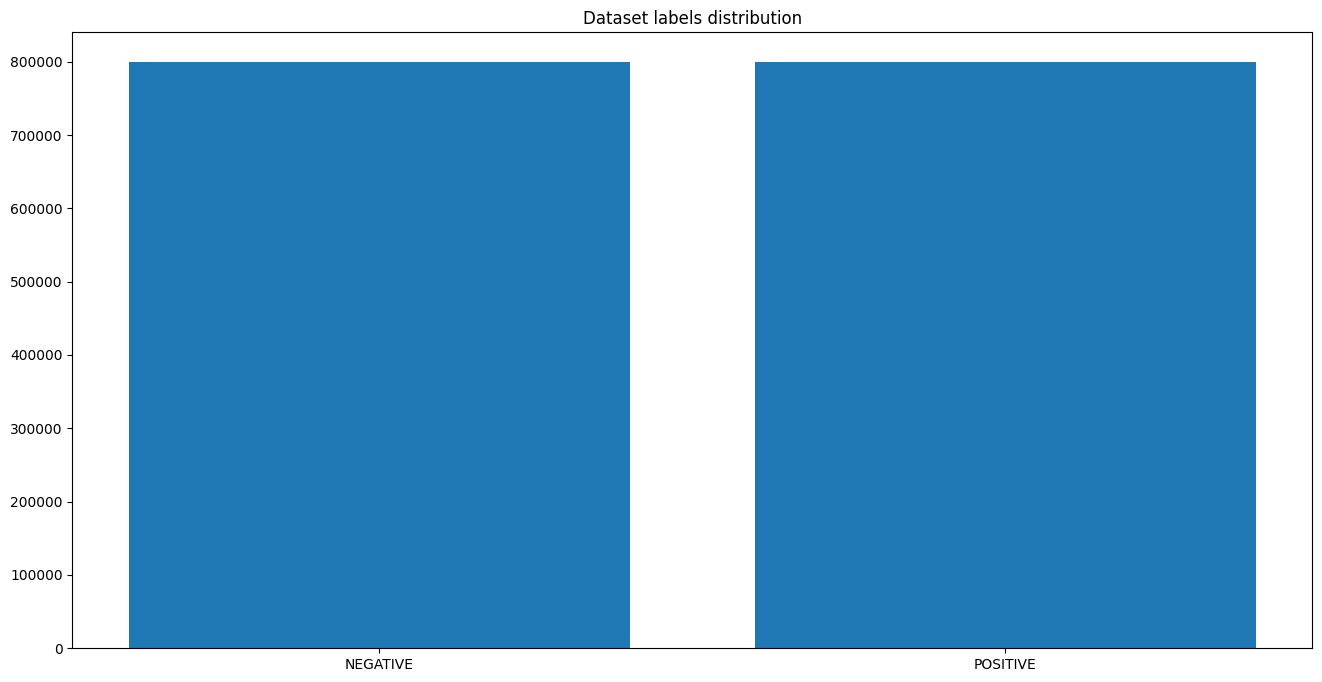

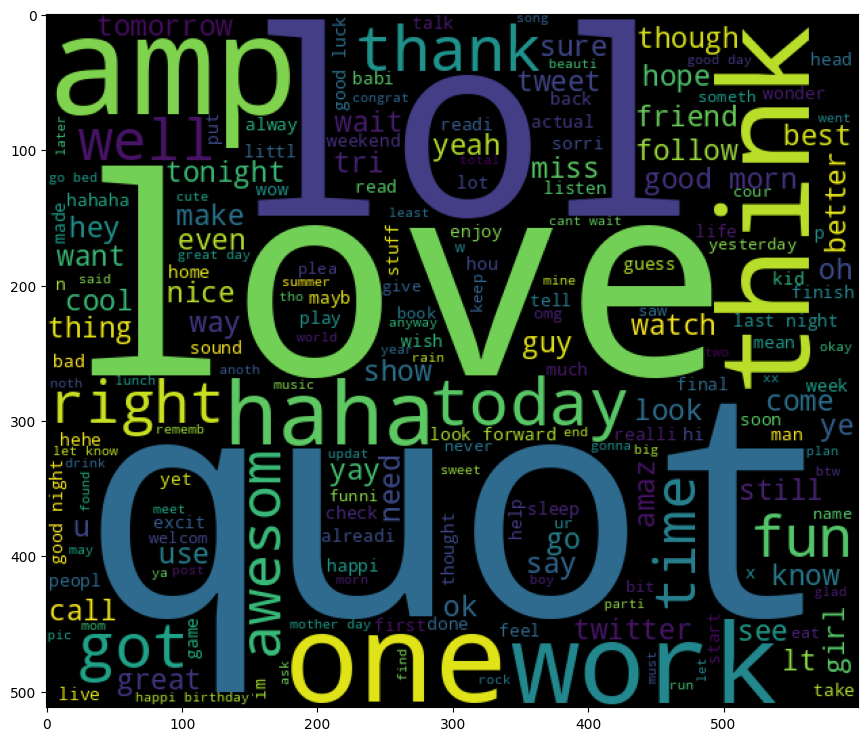

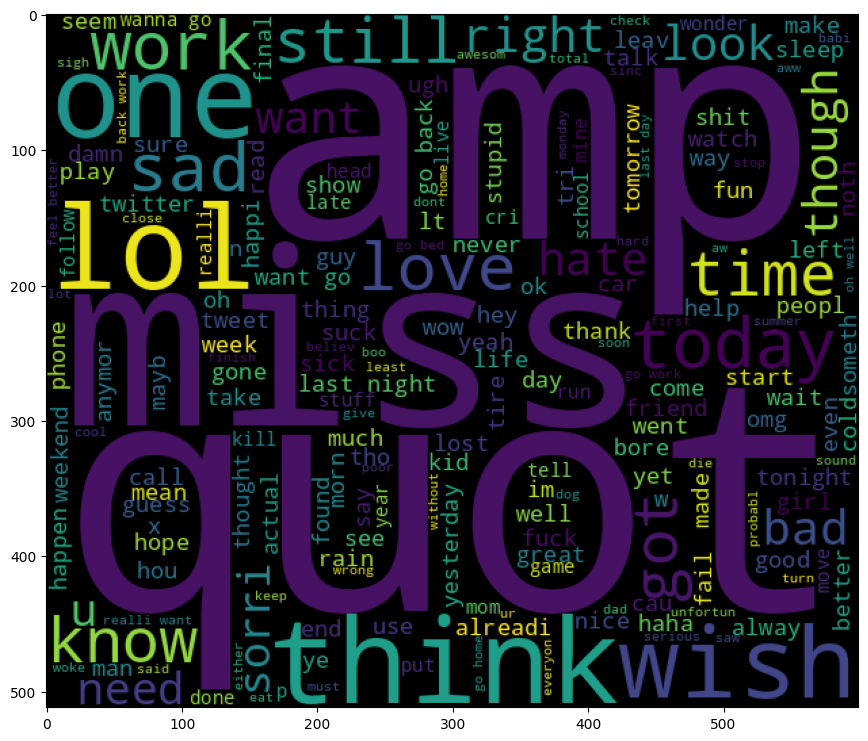

In [ ]:
from collections import Counter

# Visualize label distribution
cnt = Counter(df['target'])
plt.figure(figsize=(16,8))
plt.bar(cnt.keys(), cnt.values())
plt.title("Dataset labels distribution")
plt.show()

# Create word clouds for positive and negative tweets
positive_tweets = ' '.join(list(df[df['target'] == 'POSITIVE']['text']))
negative_tweets = ' '.join(list(df[df['target'] == 'NEGATIVE']['text']))

def create_word_cloud(data):
    data_wc = WordCloud(width=600,height=512).generate(data)
    plt.figure(figsize=(13,9))
    plt.imshow(data_wc)
    plt.show()

create_word_cloud(positive_tweets)
create_word_cloud(negative_tweets)


#**5. Split Data and Vectorize Text**

In [ ]:
# Prepare the data by splitting it into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['target'], test_size=0.3, random_state=42)

# TfidfVectorizer to convert text data into TF-IDF features
vectorizer = TfidfVectorizer(max_features=10000)

# Fit and transform the training data
X_train_tfidf = vectorizer.fit_transform(X_train)

# Transform the test data
X_test_tfidf = vectorizer.transform(X_test)


#**6. Hyperparameter Tuning for Logistic Regression**

#GridSearchCV for Logistic Regression ✅

In [ ]:
# Hyperparameter Tuning with GridSearchCV for Logistic Regression
logistic_params = {
    'C': [0.1, 1, 10],
    'solver': ['newton-cg']
}
logistic_model = LogisticRegression(random_state=42)
logistic_grid = GridSearchCV(logistic_model, logistic_params, cv=5, n_jobs=-1, scoring='accuracy')
logistic_grid.fit(X_train_tfidf, y_train)
best_logistic = logistic_grid.best_estimator_
y_pred_logistic = best_logistic.predict(X_test_tfidf)
accuracy_logistic = accuracy_score(y_test, y_pred_logistic)
print(f"Best Logistic Regression Accuracy: {accuracy_logistic}")
print(confusion_matrix(y_test,y_pred_logistic))
print(classification_report(y_test, y_pred_logistic))


Best Logistic Regression Accuracy: 0.77176875
[[179726  59635]
 [ 49916 190723]]
              precision    recall  f1-score   support

    NEGATIVE       0.78      0.75      0.77    239361
    POSITIVE       0.76      0.79      0.78    240639

    accuracy                           0.77    480000
   macro avg       0.77      0.77      0.77    480000
weighted avg       0.77      0.77      0.77    480000



#**7. Train and Evaluate Other Models**

#SVM ✅

In [ ]:
# Initialize SVM
svm_model = LinearSVC(random_state=42)
svm_model.fit(X_train_tfidf, y_train)
y_pred_svm = svm_model.predict(X_test_tfidf)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(f"SVM Accuracy: {accuracy_svm}")
print(confusion_matrix(y_test,y_pred_svm))
print(classification_report(y_test, y_pred_svm))




SVM Accuracy: 0.77000625
[[178513  60848]
 [ 49549 191090]]
              precision    recall  f1-score   support

    NEGATIVE       0.78      0.75      0.76    239361
    POSITIVE       0.76      0.79      0.78    240639

    accuracy                           0.77    480000
   macro avg       0.77      0.77      0.77    480000
weighted avg       0.77      0.77      0.77    480000



#Random Forest ✅

In [ ]:
# Initialize Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train_tfidf, y_train)
y_pred_rf = rf_model.predict(X_test_tfidf)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Accuracy: {accuracy_rf}")
print(confusion_matrix(y_test,y_pred_rf))
print(classification_report(y_test, y_pred_rf))



Random Forest Accuracy: 0.7663416666666667
[[183333  56028]
 [ 56128 184511]]
              precision    recall  f1-score   support

    NEGATIVE       0.77      0.77      0.77    239361
    POSITIVE       0.77      0.77      0.77    240639

    accuracy                           0.77    480000
   macro avg       0.77      0.77      0.77    480000
weighted avg       0.77      0.77      0.77    480000



#Gradient Boosting ✅

In [ ]:
# Initialize Gradient Boosting Classifier
gbm_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
gbm_model.fit(X_train_tfidf, y_train)
y_pred_gbm = gbm_model.predict(X_test_tfidf)
accuracy_gbm = accuracy_score(y_test, y_pred_gbm)
print(f"Gradient Boosting Accuracy: {accuracy_gbm}")
print(classification_report(y_test, y_pred_gbm))

Gradient Boosting Accuracy: 0.6822270833333334
              precision    recall  f1-score   support

    NEGATIVE       0.79      0.49      0.61    239361
    POSITIVE       0.63      0.87      0.73    240639

    accuracy                           0.68    480000
   macro avg       0.71      0.68      0.67    480000
weighted avg       0.71      0.68      0.67    480000



#GridSearchCV for SVM ✅

In [ ]:
# defining parameter range
param_grid = {'C': [0.1, 1]}

svm_model = LinearSVC(random_state=42)
svm_grid = GridSearchCV(svm_model, param_grid, refit = True, verbose = 3)
svm_grid.fit(X_train_tfidf, y_train)
best_svm = svm_grid.best_estimator_
y_pred_svm = best_svm.predict(X_test_tfidf)

# print best parameter after tuning
print(svm_grid.best_params_)

# print how our model looks after hyper-parameter tuning
print(svm_grid.best_estimator_)

# print classification report
print(classification_report(y_test,y_pred_svm))
print(confusion_matrix(y_test,y_pred_svm))

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV 1/5] END .............................C=0.1;, score=0.771 total time=  11.2s
[CV 2/5] END .............................C=0.1;, score=0.771 total time=  11.3s
[CV 3/5] END .............................C=0.1;, score=0.771 total time=   9.9s
[CV 4/5] END .............................C=0.1;, score=0.771 total time=  11.2s
[CV 5/5] END .............................C=0.1;, score=0.771 total time=  10.4s
[CV 1/5] END ...............................C=1;, score=0.770 total time=  31.2s
[CV 2/5] END ...............................C=1;, score=0.770 total time=  32.0s
[CV 3/5] END ...............................C=1;, score=0.770 total time=  31.6s
[CV 4/5] END ...............................C=1;, score=0.770 total time=  31.6s
[CV 5/5] END ...............................C=1;, score=0.769 total time=  31.4s
{'C': 0.1}
LinearSVC(C=0.1, random_state=42)
              precision    recall  f1-score   support

    NEGATIVE       0.78      0